Naive Bayes

Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

We divide the target variable (quality) into 3 classes.
- Class 0 : Bad (quality <= 4)
- Class 1 : Average (5 <= quality <= 7)
- Class 2 : Good (8 <= quality)

In [10]:
# Load data
df_white = pd.read_csv('winequality-white.csv', delimiter=';')
df_red = pd.read_csv('winequality-red.csv')

# Select dataset
df = df_white
#df = df_red

# Create a quality label (low, medium, high) based on quality score
df['quality_label'] = df['quality'].apply(lambda x: 'Poor' if x < 5 else 'Average' if x <= 7 else 'High')

# Encode 'quality_label' to numerical values
label_enc = LabelEncoder()
df['quality_label'] = label_enc.fit_transform(df['quality_label'])

df = df.drop_duplicates()

# Separate the data into features and target
X = df.drop(['quality', 'quality_label'], axis=1).to_numpy()
y = df['quality_label'].to_numpy()

In [11]:
# Initialize scaler
rb_scaler = RobustScaler()

# Split the data into training and testing sets FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the data after to prevent data leakage
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

In [12]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

### Evaluation

In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Encoded Quality Labels:\n', dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))
print('\n',classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100:.2f} %')


Encoded Quality Labels:
 {'Average': 0, 'High': 1, 'Poor': 2}

               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1096
           1       0.13      0.39      0.20        41
           2       0.25      0.27      0.26        52

    accuracy                           0.83      1189
   macro avg       0.44      0.51      0.45      1189
weighted avg       0.88      0.83      0.85      1189

Accuracy: 82.76 %


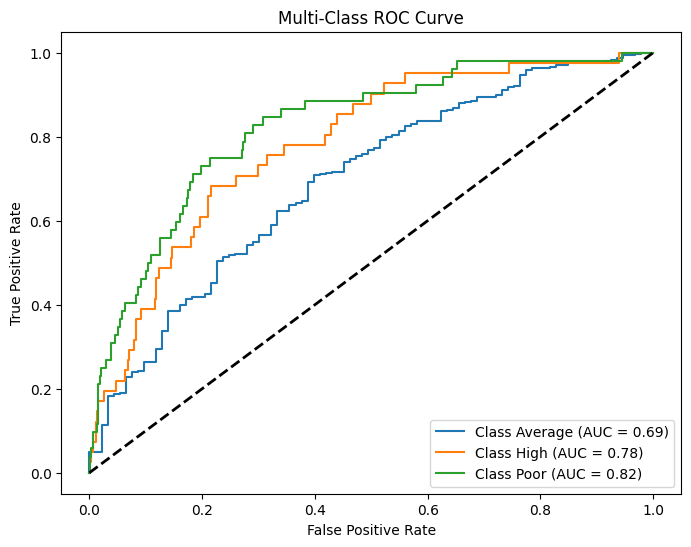

In [14]:
# Convert y_test and y_pred to binary format for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encode labels
y_score = model.predict_proba(X_test)  # Get probability scores for each class

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_enc.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


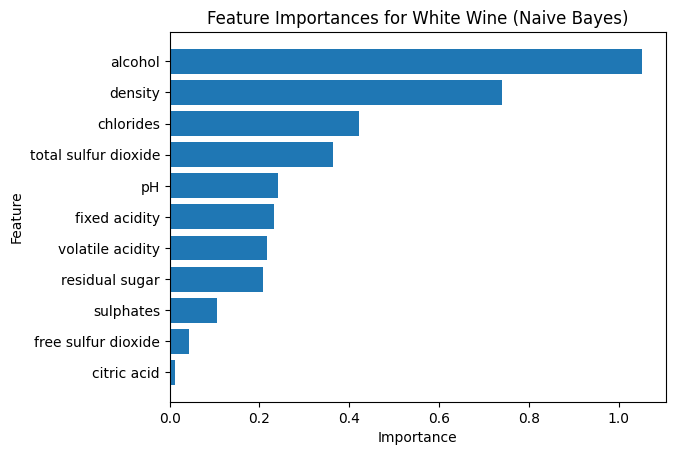

In [15]:
# Compute importance scores
feature_names = df.columns
feature_names = feature_names.drop(['quality', 'quality_label'])

importance = np.abs(model.theta_[0] - model.theta_[1]) / np.sqrt(model.var_[0])
feature_importance = sorted(zip(feature_names, importance), key=lambda x: -x[1])

df_importance = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])
df_importance = df_importance.sort_values(by="Importance", ascending=False)

plt.barh(df_importance['Feature'][::-1], df_importance['Importance'][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances for White Wine (Naive Bayes)")
plt.show()